## Heading here

Load the data and plot it.  Note that to make the index a time object in python, we need to do a conversion
$superscript^2 subscriot_7 x^{n-1}$

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


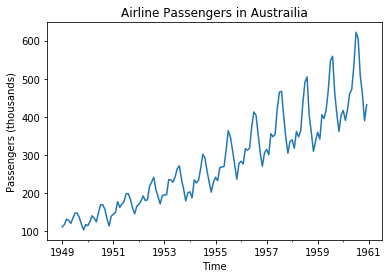

In [97]:
import sys
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True

if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline
 
data = read_csv('AirPassengers.csv',sep=',')
air_pop=data['#Passengers']
air_pop.index=pd.to_datetime(data['Month'])
print(air_pop.head())
fig = plt.figure()

air_pop.plot()
plt.title("Airline Passengers in Austrailia")
plt.xlabel("Time")
plt.ylabel('Passengers (thousands)')
plt.show()


This is just a function that implements the Dickey-Fuller test and plots data along with rolling mean and standard deviation

In [75]:

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


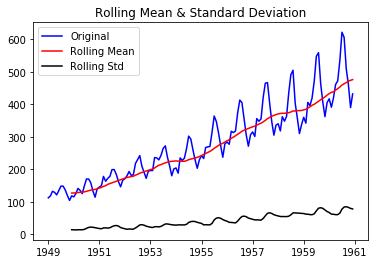

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [76]:
test_stationarity(air_pop)

Now we will subtract the trend from our data to make it (more) stationary

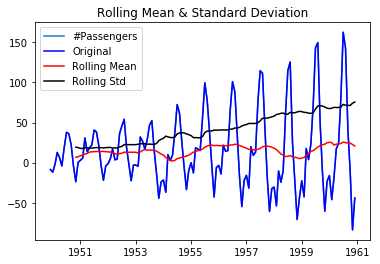

Results of Dickey-Fuller Test:
Test Statistic                  -3.164968
p-value                          0.022104
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [77]:
#passes test statistic
moving_avg = air_pop.rolling(12).mean()
no_trend = air_pop - moving_avg
plt.plot(no_trend)
plt.title("Passenger Data with Rolling Mean Removed")
test_stationarity(no_trend.dropna())

Now we do a variable change from y to ln y.  Not that in python the "log" function is actually natural log, ln.  Also note that the test statistic did not change hardly at all, even though the series looks much better.  
 
 In reality this data shows some seasonality, and there are seasonal models available, but for the purposes of the exercise we will ignore seasonality.

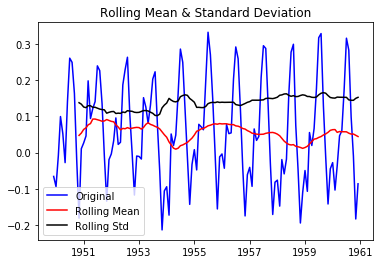

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [78]:
import numpy as np
log_air_pop=np.log(air_pop)
log_moving_avg = log_air_pop.rolling(12).mean()
log_no_trend=log_air_pop - log_moving_avg
test_stationarity(log_no_trend.dropna())

This next set of charts simply shows all the pieces of the function.  Note that while it does include seasonality, there still seems to be residual seasonality in the residuals.

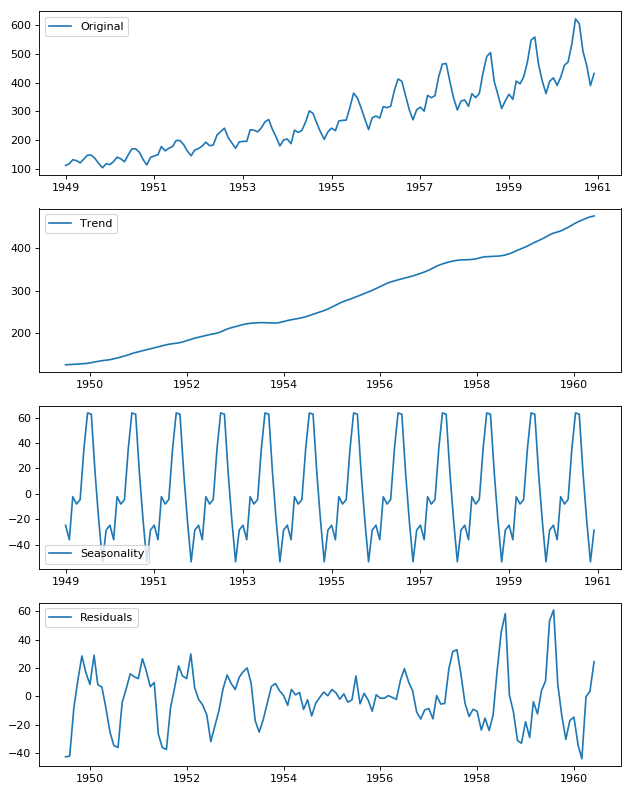

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(air_pop)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(num=None, figsize=(8, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(411)
plt.plot(air_pop, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Next we will try some differencing to try and eliminate seasonality and make the series further staionary.  This determines if we use a difference term or not.  In this example, 1 shift ($y_t - y_{t-1}$) is used, so d=1

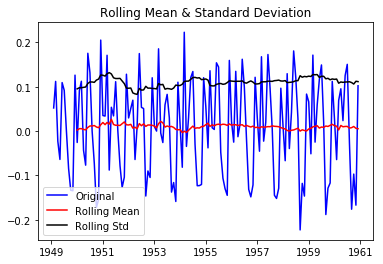

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [80]:
diff_air_pop = log_air_pop-log_air_pop.shift()
test_stationarity(diff_air_pop.dropna())

Now we take a look at the Autocorrelation and Partial Autocorrelation plots

Text(0.5,1,'Autocorrelation Function')

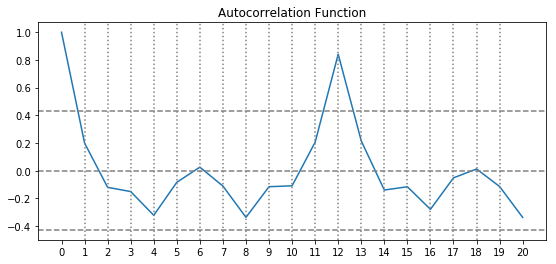

In [81]:
from statsmodels.tsa.stattools import acf, pacf
acf_air_plot = acf(diff_air_pop.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

Text(0.5,1,'Partial Autocorrelation Function')

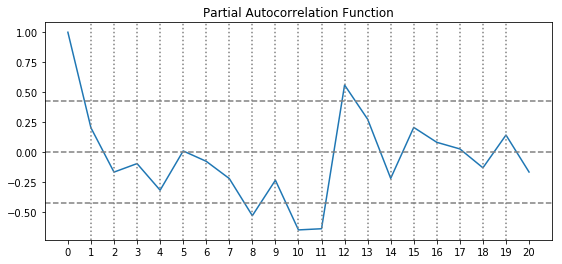

In [82]:
pacf_air_plot = pacf(diff_air_pop.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function')

Now we fit a model of the proper order and look at the output

In [83]:
from statsmodels.tsa.arima_model import ARIMA


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:            #Passengers   No. Observations:                  143
Model:                     ARMA(1, 1)   Log Likelihood                 124.804
Method:                       css-mle   S.D. of innovations              0.101
Date:                Sat, 02 Jun 2018   AIC                           -241.608
Time:                        00:17:10   BIC                           -229.756
Sample:                    02-01-1949   HQIC                          -236.792
                         - 12-01-1960                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0098      0.010      0.993      0.322      -0.010       0.029
ar.L1.#Passengers    -0.5826      0.128     -4.536      0.000      -0.834      -0.331
ma.L1.#Passengers     0.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


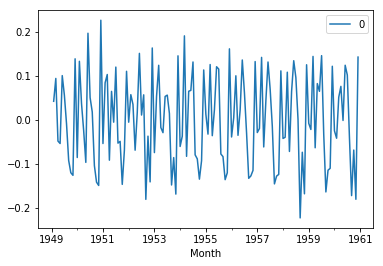

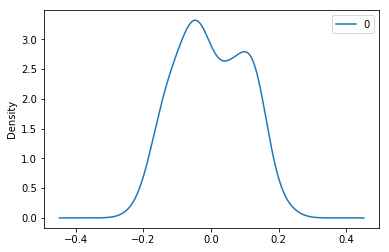

                0
count  143.000000
mean    -0.000026
std      0.101389
min     -0.223351
25%     -0.078643
50%     -0.009057
75%      0.089547
max      0.227127


In [84]:
model = ARIMA(diff_air_pop.dropna(), order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

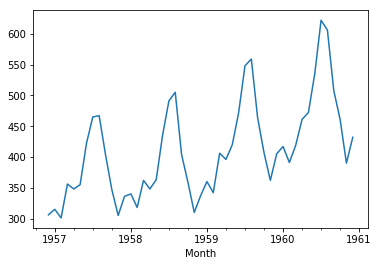

In [85]:

air_pop[-49:].plot()

Now I am just going to do a brute force searc for parameters and find the best  ones.

1.2697630431892137


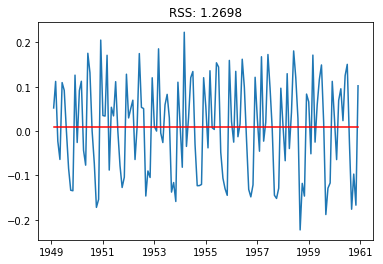

0 0 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


1.2347218949983345


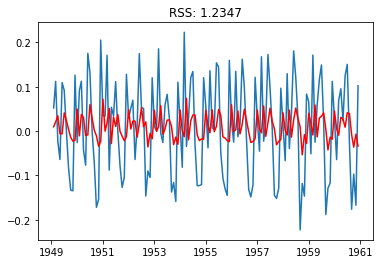

0 0 1
1.213317821474303


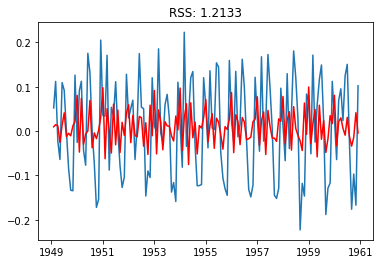

0 0 2


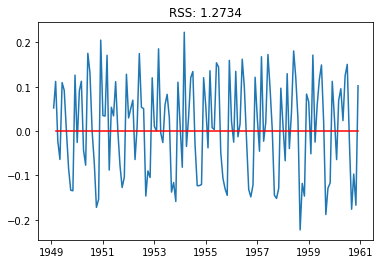

0 1 0


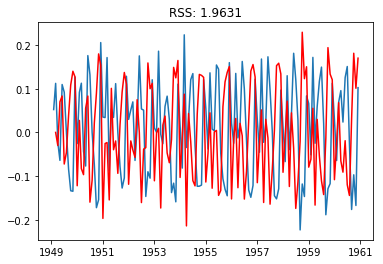

0 1 1


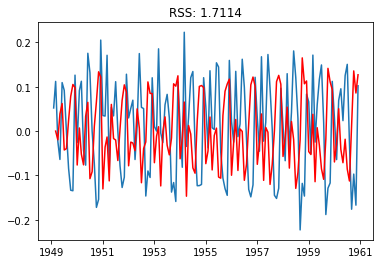

0 1 2


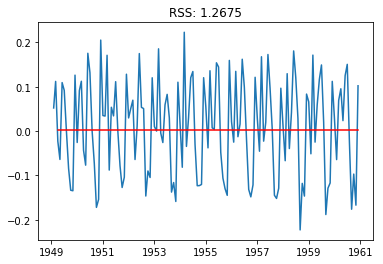

0 2 0


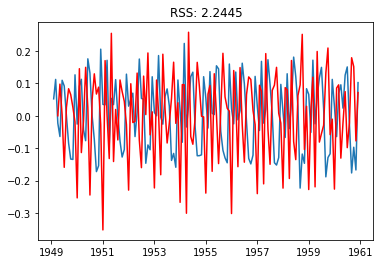

0 2 1


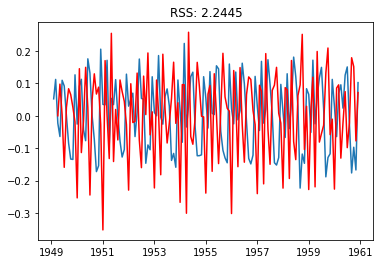

0 2 2


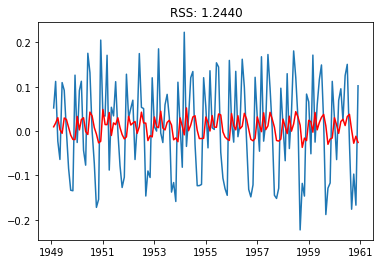

1 0 0
1.2081934014770117


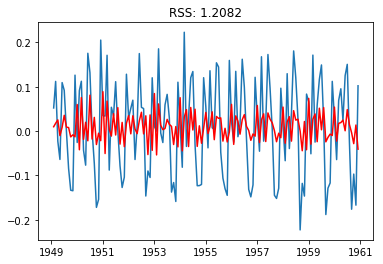

1 0 1
1.1033131558189289


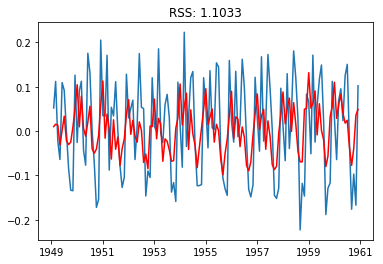

1 0 2


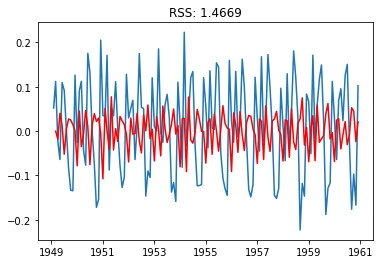

1 1 0


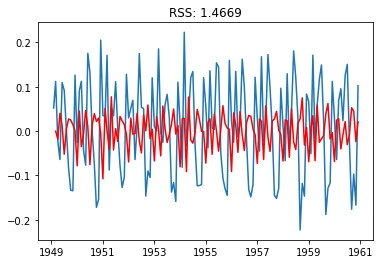

1 1 1


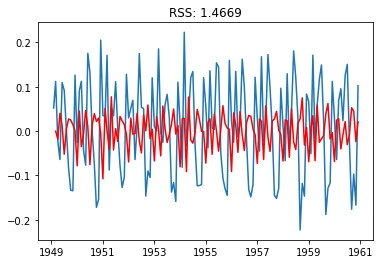

1 1 2


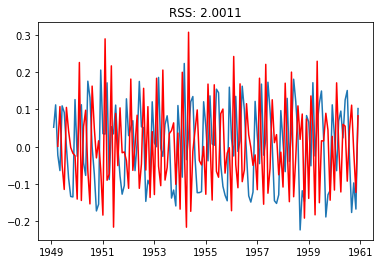

1 2 0


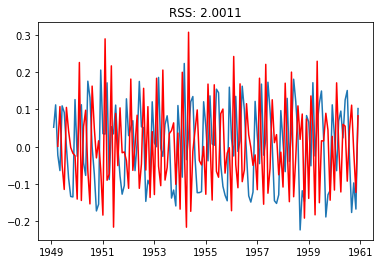

1 2 1


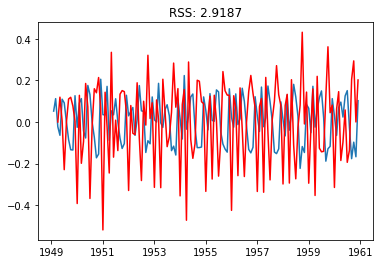

1 2 2


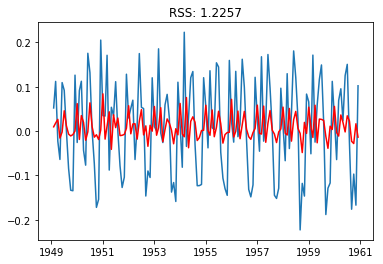

2 0 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1.0841183085378654


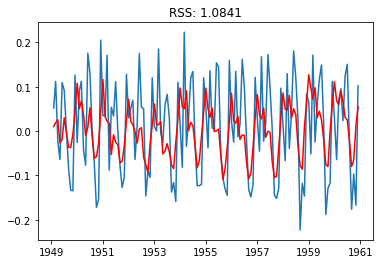

2 0 1
1.0144712731735472


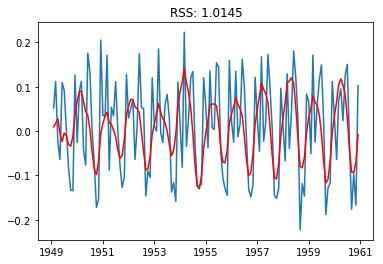

2 0 2


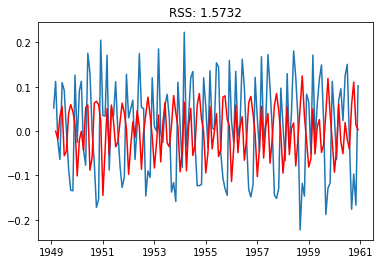

2 1 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


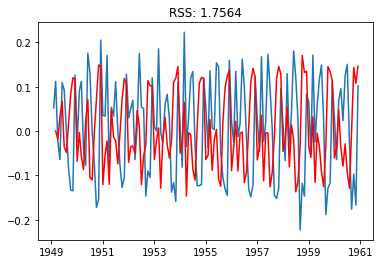

2 1 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


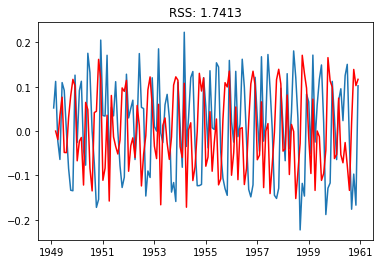

2 1 2


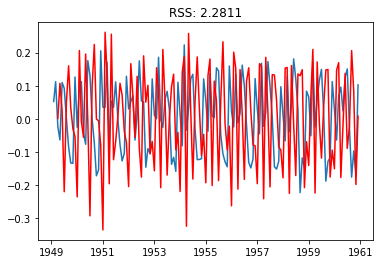

2 2 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


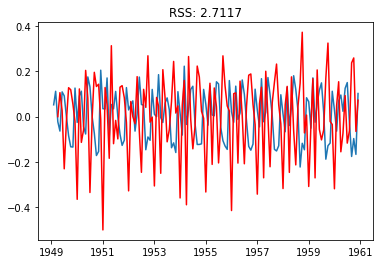

2 2 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


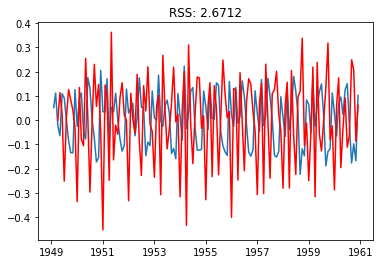

2 2 2


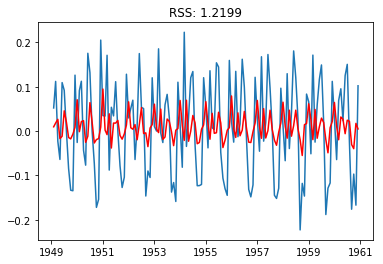

3 0 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


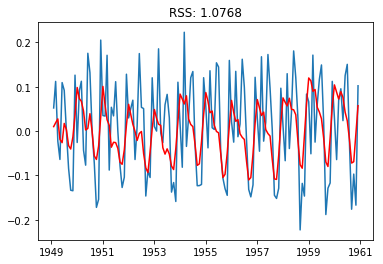

3 0 1


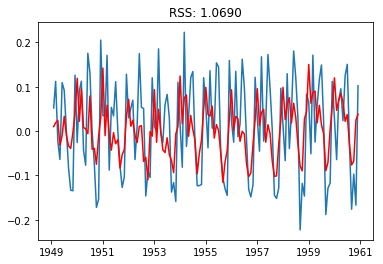

3 0 2


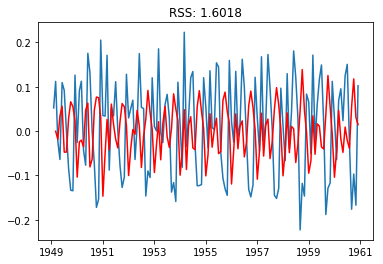

3 1 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


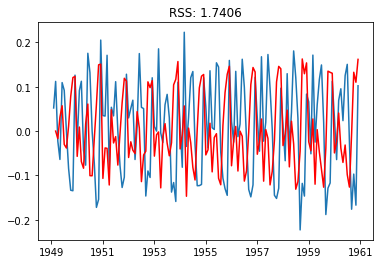

3 1 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


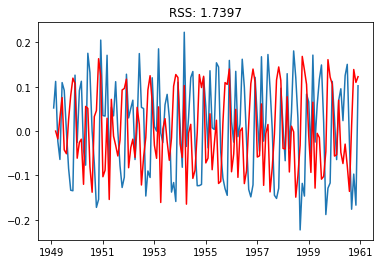

3 1 2


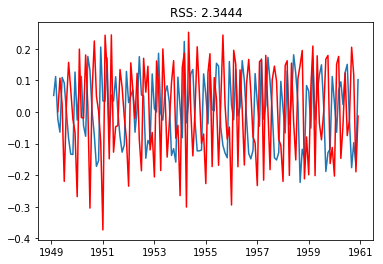

3 2 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


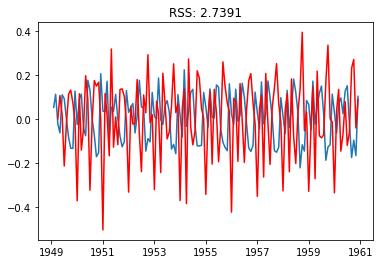

3 2 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


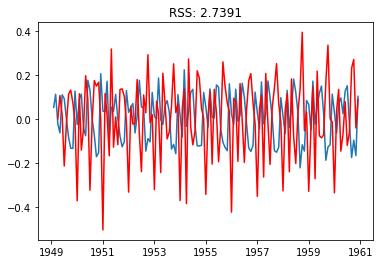

3 2 2


In [86]:
air_pop = air_pop.astype(float)
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(diff_air_pop.dropna(), order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(diff_air_pop)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(diff_air_pop)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(p,d,q)

In [87]:
print(loss_best)
print(best_ints)

1.0144712731735472
[2, 0, 2]


In [98]:
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as web
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2018, 2, 1)
price = web.DataReader('GIS', 'iex', start, end)['close']
price.index = pd.to_datetime(price.index)

5y


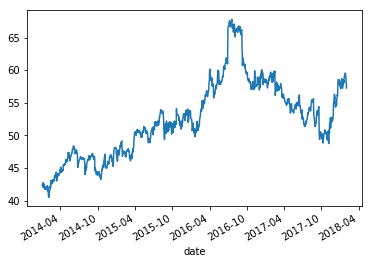

In [99]:
price.plot()

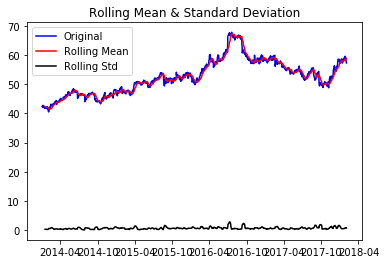

Results of Dickey-Fuller Test:
Test Statistic                   -1.882037
p-value                           0.340558
#Lags Used                        0.000000
Number of Observations Used    1028.000000
Critical Value (1%)              -3.436727
Critical Value (5%)              -2.864356
Critical Value (10%)             -2.568269
dtype: float64


In [100]:
test_stationarity(price)

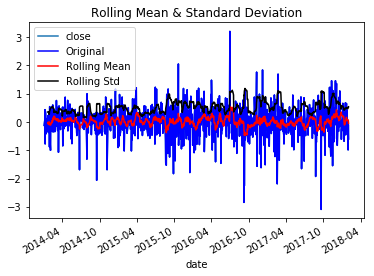

Results of Dickey-Fuller Test:
Test Statistic                  -32.853688
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1027.000000
Critical Value (1%)              -3.436733
Critical Value (5%)              -2.864358
Critical Value (10%)             -2.568271
dtype: float64


In [101]:
diff=price-price.shift()
diff.dropna(inplace=True)
diff.plot()
test_stationarity(diff)

Text(0.5,1,'Autocorrelation Function')

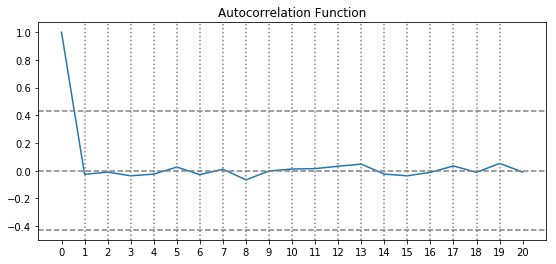

In [102]:
acf_air_plot = acf(diff, nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

Text(0.5,1,'Partial Autocorrelation Function')

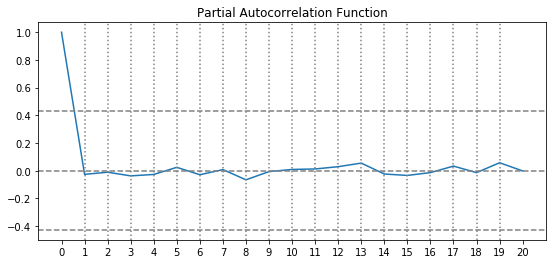

In [103]:
pacf_air_plot = pacf(diff, nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_air_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_air_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1028
Model:                     ARMA(1, 0)   Log Likelihood                -841.652
Method:                       css-mle   S.D. of innovations              0.549
Date:                Sat, 02 Jun 2018   AIC                           1689.303
Time:                        00:20:43   BIC                           1704.109
Sample:                    01-03-2014   HQIC                          1694.923
                         - 02-01-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0145      0.017      0.870      0.385      -0.018       0.047
ar.L1.close    -0.0264      0.031     -0.847      0.397      -0.088       0.035
                                    Roots       

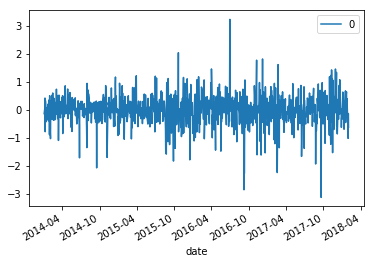

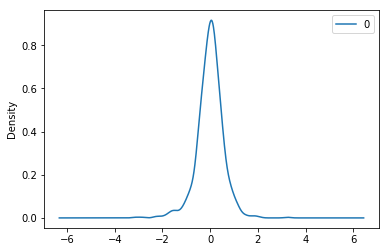

                 0
count  1028.000000
mean     -0.000003
std       0.548963
min      -3.136106
25%      -0.278359
50%       0.023737
75%       0.302583
max       3.243495


In [104]:
model = ARIMA(diff, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

17.598653711320445


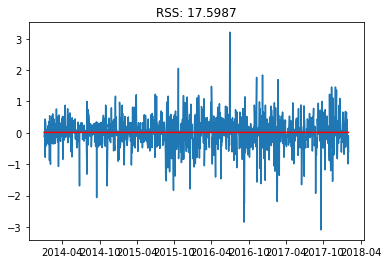

0 0 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


17.592372788226474


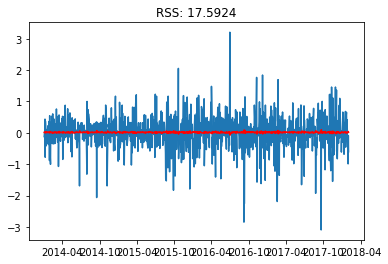

0 0 1
17.591001069787364


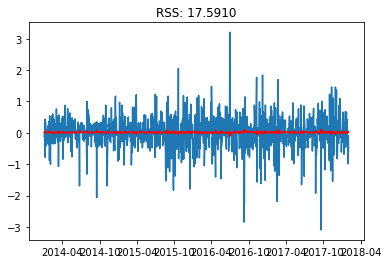

0 0 2


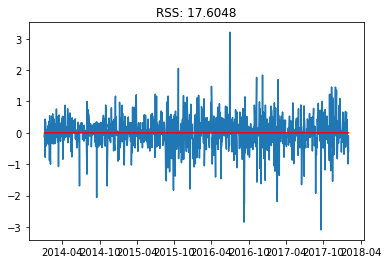

0 1 0


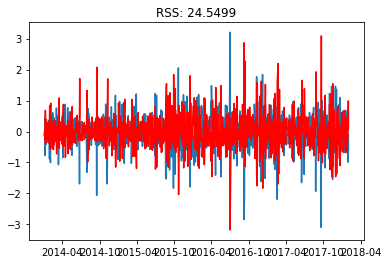

0 1 1


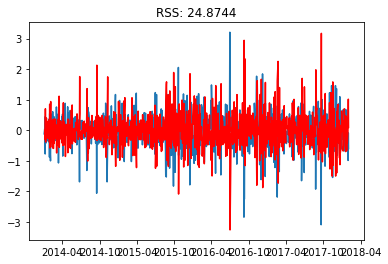

0 1 2


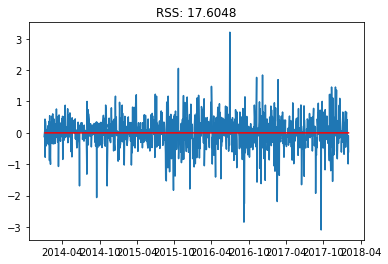

0 2 0


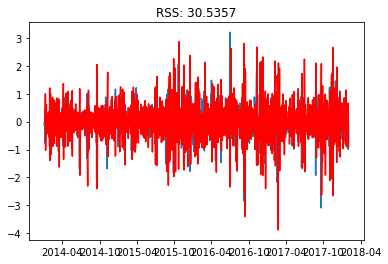

0 2 1


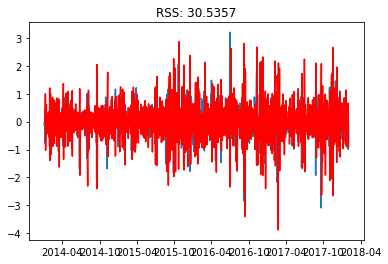

0 2 2


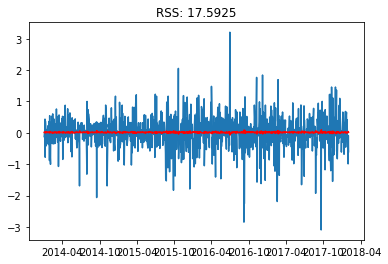

1 0 0
17.57923413067854


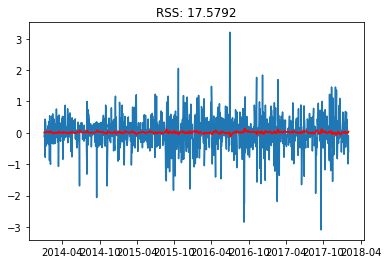

1 0 1


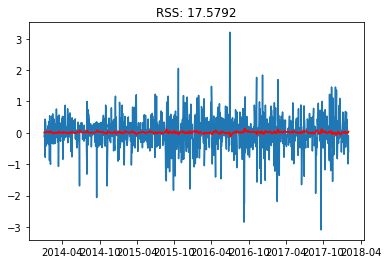

1 0 2


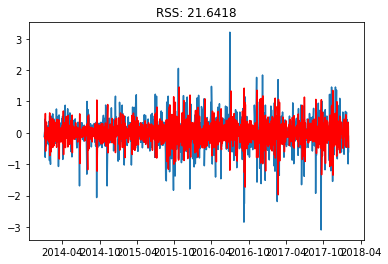

1 1 0


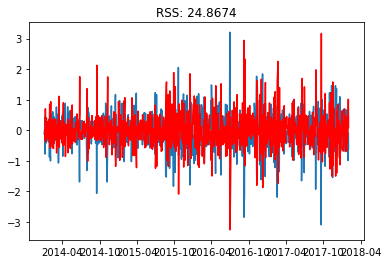

1 1 1


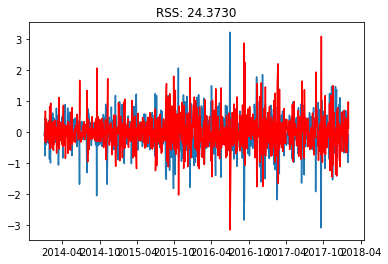

1 1 2


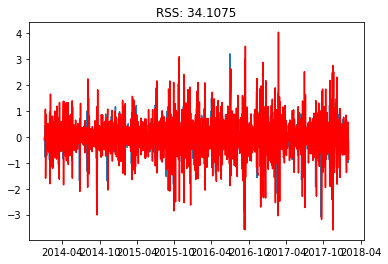

1 2 0


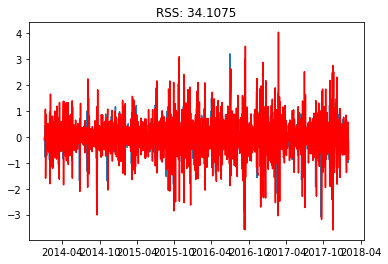

1 2 1


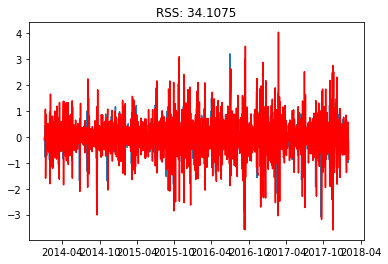

1 2 2


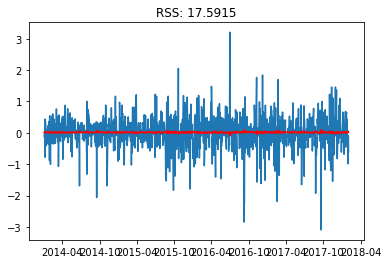

2 0 0
17.57904738841566


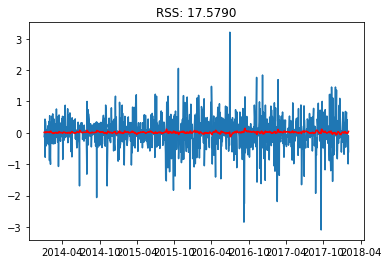

2 0 1


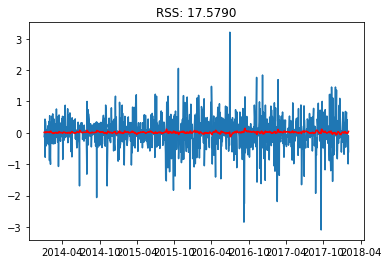

2 0 2


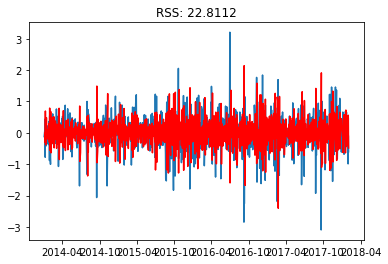

2 1 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


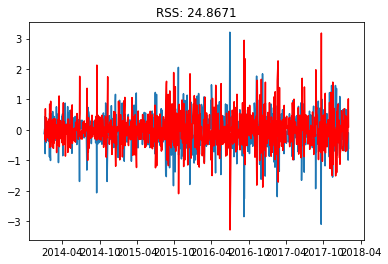

2 1 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


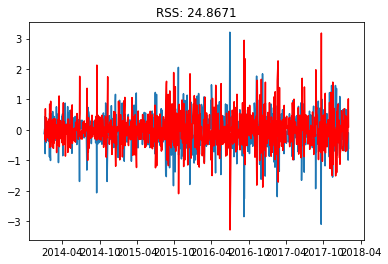

2 1 2


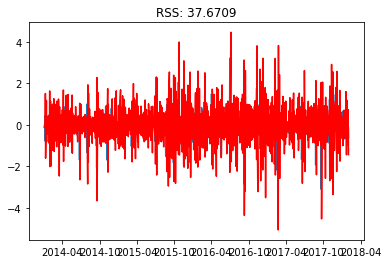

2 2 0


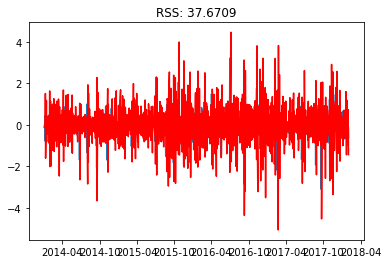

2 2 1


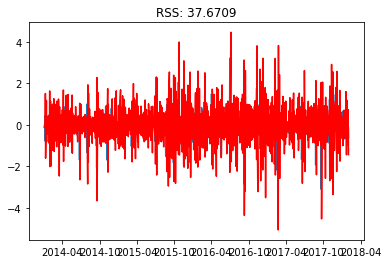

2 2 2


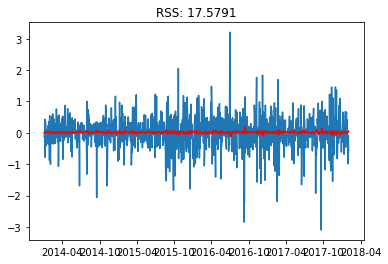

3 0 0
17.574523195944337


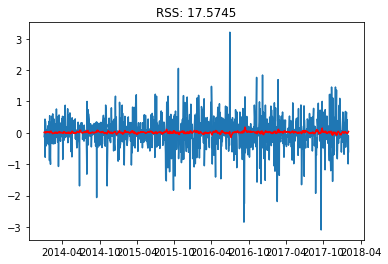

3 0 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


17.524941737680614


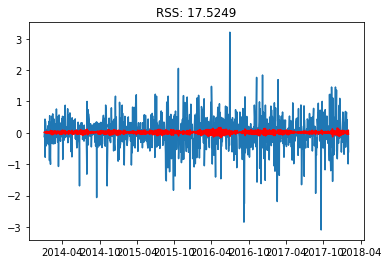

3 0 2


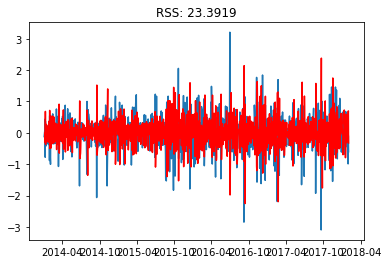

3 1 0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


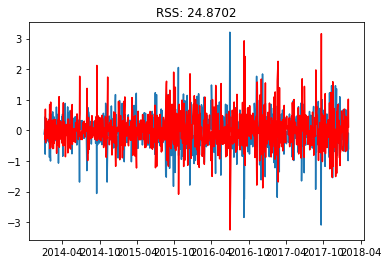

3 1 1


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


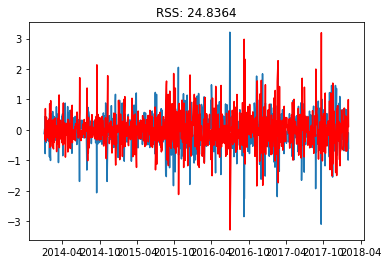

3 1 2


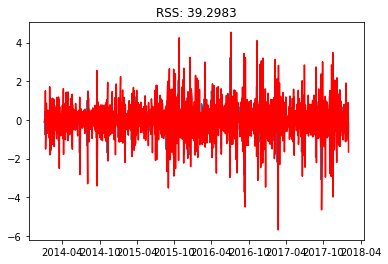

3 2 0


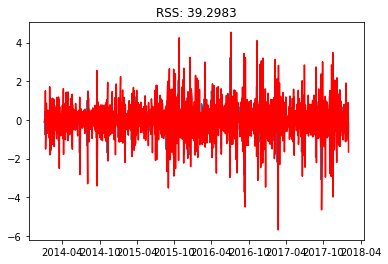

3 2 1


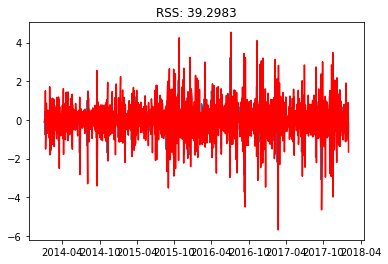

3 2 2


In [105]:
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(diff, order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(diff)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(diff)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(p,d,q)

In [106]:
print(loss_best)
print(best_ints)

17.524941737680614
[3, 0, 2]
